In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../Scripts'))

In [2]:
from load_data import load_data_from_postgres

In [3]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL
df = load_data_from_postgres(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

c:\Users\lenovo\Documents\10acadmy\TellCo\Scripts\load_data.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Successfully loaded the data


## preprocessor

In [18]:
from utils import OverviewAnalysis
data = OverviewAnalysis(df)

In [19]:
# Handle missing values and outliers
data.handle_missing_values(df)
data.handle_outliers()

Missing values handled.
Outliers handled.


## User Engagement Analysis

### Aggregating Engagement Metrics

In [20]:
# Step 1: Aggregating by user (assuming MSISDN/Number represents the user)
aggregated_data = df.groupby('MSISDN/Number').agg({
    'Bearer Id': 'count',             # Number of xDR sessions
    'Dur. (ms)': 'sum',               # Total session duration
    'Total DL (Bytes)': 'sum',        # Total download data
    'Total UL (Bytes)': 'sum',        # Total upload data
    'Youtube DL (Bytes)': 'sum',      # YouTube download
    'Youtube UL (Bytes)': 'sum',      # YouTube upload
    'Social Media DL (Bytes)': 'sum', # Social Media download
    'Social Media UL (Bytes)': 'sum', # Social Media upload
    'Netflix DL (Bytes)': 'sum',      # Netflix download
    'Netflix UL (Bytes)': 'sum',      # Netflix upload
    'Gaming DL (Bytes)': 'sum',       # Gaming download
    'Gaming UL (Bytes)': 'sum',       # Gaming upload
    'Google DL (Bytes)': 'sum',       # Google download
    'Google UL (Bytes)': 'sum',       # Google upload
    'Email DL (Bytes)': 'sum',        # Email download
    'Email UL (Bytes)': 'sum'         # Email upload  
})

# Step 2: Calculate total data volume (DL + UL)
aggregated_data['Total Data Volume (Bytes)'] = aggregated_data['Total DL (Bytes)'] + aggregated_data['Total UL (Bytes)']

# Step 3: Rename columns for clarity
aggregated_data.rename(columns={'Bearer Id': 'Number of xDR Sessions', 'Dur. (ms)': 'Session Duration (ms)'}, inplace=True)

# Step 4: Display the aggregated data per user
print(aggregated_data.head())


               Number of xDR Sessions  Session Duration (ms)  \
MSISDN/Number                                                  
3.360100e+10                        1               116720.0   
3.360100e+10                        1               181230.0   
3.360100e+10                        1               134969.0   
3.360101e+10                        1                49878.0   
3.360101e+10                        2                37104.0   

               Total DL (Bytes)  Total UL (Bytes)  Youtube DL (Bytes)  \
MSISDN/Number                                                           
3.360100e+10       8.426375e+08        36053108.0          14900201.0   
3.360100e+10       1.207552e+08        36104459.0           5324251.0   
3.360100e+10       5.566597e+08        39306820.0           2137272.0   
3.360101e+10       4.019932e+08        20327526.0           4393123.0   
3.360101e+10       1.363130e+09        94280527.0          10339971.0   

               Youtube UL (Bytes)  Soci

In [21]:
# Create a new column for total duration and total data
df['Total Duration'] = df['Dur. (ms)']
df['Total Data'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']

# Create decile classes based on total duration
df['Decile Class'] = pd.qcut(df['Total Duration'], 10, labels=False, duplicates='drop')

# Compute total data per decile
decile_data = df.groupby('Decile Class')['Total Data'].sum()
print(decile_data)

Decile Class
0    7.439191e+12
1    7.444851e+12
2    7.478151e+12
3    1.614182e+13
4    6.089083e+12
5    7.436821e+12
6    7.416929e+12
7    7.458742e+12
8    7.459600e+12
Name: Total Data, dtype: float64


In [22]:
# Aggregating session frequency, duration, and traffic per MSISDN/Number (customer ID)
user_engagement = df.groupby('MSISDN/Number').agg({
    'Dur. (ms)': 'sum',  # Total session duration
    'Total DL (Bytes)': 'sum',  # Total Download traffic
    'Total UL (Bytes)': 'sum',  # Total Upload traffic
    'MSISDN/Number': 'count', # Session frequency
    'Total Duration': 'sum'
}).rename(columns={'MSISDN/Number': 'session_frequency'})

# Calculate total traffic (download + upload)
user_engagement['total_traffic'] = user_engagement['Total DL (Bytes)'] + user_engagement['Total UL (Bytes)' ]
user_engagement['total_duration'] = user_engagement['Total Duration']
# Sorting and displaying top 10 customers per engagement metric
top_10_session_freq = user_engagement.sort_values('session_frequency', ascending=False).head(10)
top_10_session_duration = user_engagement.sort_values('Dur. (ms)', ascending=False).head(10)
top_10_total_traffic = user_engagement.sort_values('total_traffic', ascending=False).head(10)

print("Top 10 Customers by Session Frequency:\n", top_10_session_freq)
print("Top 10 Customers by Session Duration:\n", top_10_session_duration)
print("Top 10 Customers by Total Traffic:\n", top_10_total_traffic)

Top 10 Customers by Session Frequency:
                   Dur. (ms)  Total DL (Bytes)  Total UL (Bytes)  \
MSISDN/Number                                                     
4.188282e+10   7.255100e+07      4.873783e+11      4.436642e+10   
3.362632e+10   8.791927e+06      7.301517e+09      6.696507e+08   
3.362578e+10   1.855375e+07      7.770043e+09      7.295774e+08   
3.361489e+10   9.966898e+06      8.156743e+09      6.894830e+08   
3.365973e+10   4.035428e+06      7.081602e+09      6.242603e+08   
3.367588e+10   4.865947e+06      7.309542e+09      5.815688e+08   
3.376054e+10   9.279434e+06      7.811295e+09      7.034786e+08   
3.366716e+10   8.744914e+06      5.052068e+09      5.663264e+08   
3.360452e+10   5.207990e+06      5.096079e+09      3.917759e+08   
3.362708e+10   4.703516e+06      5.309479e+09      4.452519e+08   

               session_frequency  Total Duration  total_traffic  \
MSISDN/Number                                                     
4.188282e+10         

###  Normalization and K-Means Clustering

In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Normalize the engagement metrics
scaler = MinMaxScaler()
user_engagement_normalized = scaler.fit_transform(user_engagement[['session_frequency', 'total_duration', 'total_traffic']])

# Apply k-means clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
user_engagement['cluster'] = kmeans.fit_predict(user_engagement_normalized)

# Compute cluster statistics
cluster_stats = user_engagement.groupby('cluster').agg(
    min_session_count=('session_frequency', 'min'),
    max_session_count=('session_frequency', 'max'),
    avg_session_count=('session_frequency', 'mean'),
    total_session_count=('session_frequency', 'sum'),
    
    min_duration=('total_duration', 'min'),
    max_duration=('total_duration', 'max'),
    avg_duration=('total_duration', 'mean'),
    total_duration=('total_duration', 'sum'),
    
    min_traffic=('total_traffic', 'min'),
    max_traffic=('total_traffic', 'max'),
    avg_traffic=('total_traffic', 'mean'),
    total_traffic=('total_traffic', 'sum')
).reset_index()

# Display cluster statistics
print(cluster_stats)

c:\Users\lenovo\Documents\10acadmy\TellCo\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


   cluster  min_session_count  max_session_count  avg_session_count  \
0        0                  1                  6           1.249360   
1        1               1066               1066        1066.000000   
2        2                  1                 18           3.275269   

   total_session_count  min_duration  max_duration  avg_duration  \
0               123984  7.142000e+03  4.044460e+05  1.156362e+05   
1                 1066  7.255100e+07  7.255100e+07  7.255100e+07   
2                24951  1.706800e+05  1.855375e+07  5.438869e+05   

   total_duration   min_traffic   max_traffic   avg_traffic  total_traffic  
0    1.147551e+10  3.324901e+07  3.271920e+09  6.172638e+08   6.125602e+13  
1    7.255100e+07  5.317447e+11  5.317447e+11  5.317447e+11   5.317447e+11  
2    4.143331e+09  5.714004e+07  8.846226e+09  1.651014e+09   1.257742e+13  


### Aggregating User Traffic Per Application

In [24]:
# List of applications to analyze (Social Media, YouTube, etc.)
applications = ['Social Media DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 
                'Google DL (Bytes)', 'Email DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']

# Aggregate total traffic per application
for app in applications:
    user_engagement[f'total_{app}'] = df.groupby('MSISDN/Number')[app].sum()

# Find the top 10 users for each application
top_10_per_application = {}
for app in applications:
    top_10_per_application[app] = user_engagement[['session_frequency', f'total_{app}']].nlargest(10, f'total_{app}')

# Display top 10 users per application
for app, top_10 in top_10_per_application.items():
    print(f"Top 10 users for {app}:")
    print(top_10)


Top 10 users for Social Media DL (Bytes):
               session_frequency  total_Social Media DL (Bytes)
MSISDN/Number                                                  
4.188282e+10                1066                   1.937715e+09
3.362632e+10                  18                   4.274384e+07
3.376054e+10                  15                   3.929765e+07
3.365973e+10                  16                   3.490044e+07
3.361489e+10                  17                   2.774974e+07
3.362578e+10                  17                   2.656412e+07
3.366716e+10                  13                   2.375375e+07
3.378632e+10                  12                   2.356866e+07
3.366907e+10                  11                   2.347705e+07
3.360313e+10                  12                   2.277668e+07
Top 10 users for Youtube DL (Bytes):
               session_frequency  total_Youtube DL (Bytes)
MSISDN/Number                                             
4.188282e+10                1066   

### Plotting the Top 3 Most Used Applications

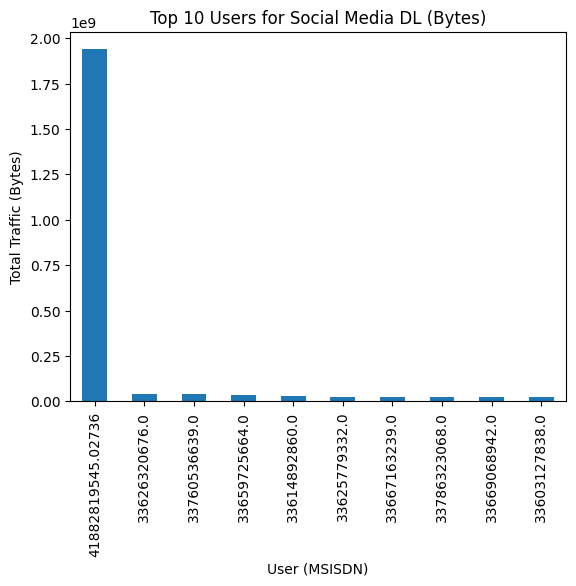

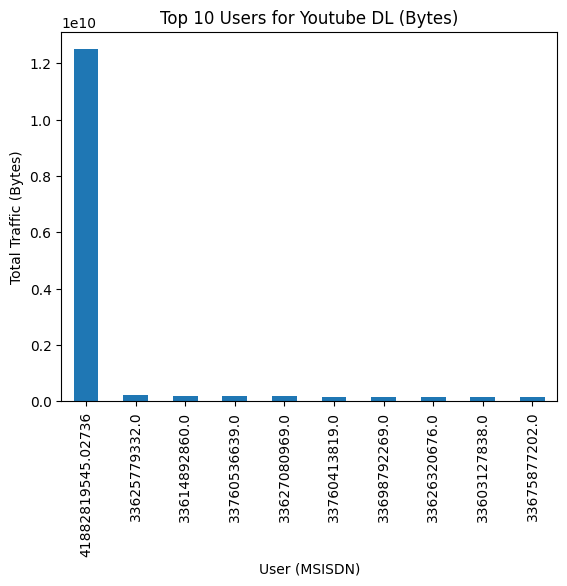

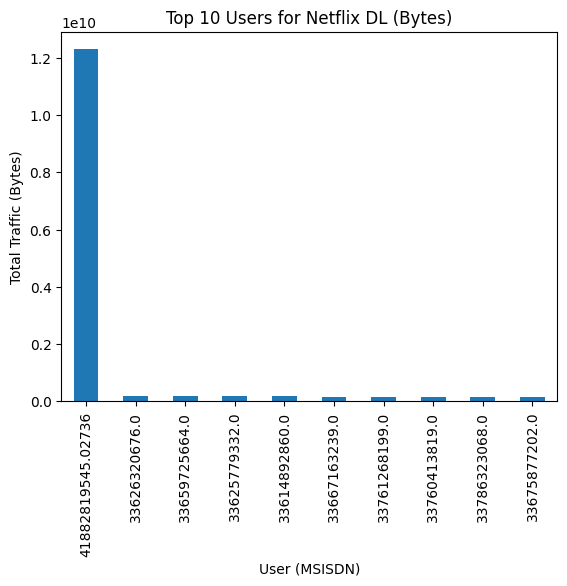

In [25]:
import matplotlib.pyplot as plt

# Select the top 3 applications based on total traffic
top_3_apps = ['Social Media DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)']

# Plot total traffic for the top 3 apps
for app in top_3_apps:
    user_engagement[f'total_{app}'].nlargest(10).plot(kind='bar')
    plt.title(f'Top 10 Users for {app}')
    plt.xlabel('User (MSISDN)')
    plt.ylabel('Total Traffic (Bytes)')
    plt.show()


### Optimal Value of k Using the Elbow Method

c:\Users\lenovo\Documents\10acadmy\TellCo\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lenovo\Documents\10acadmy\TellCo\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lenovo\Documents\10acadmy\TellCo\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lenovo\Documents\10acadmy\TellCo\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureW

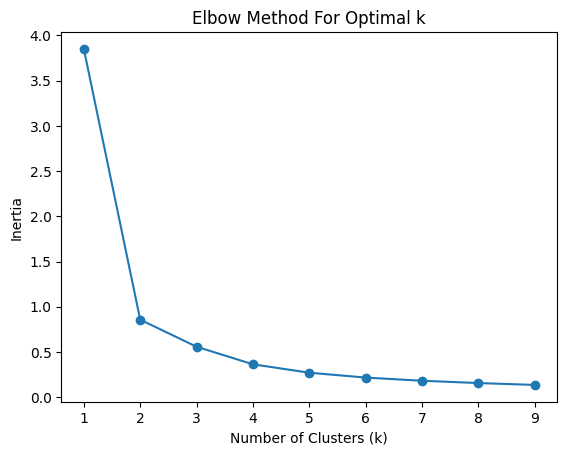

In [26]:
inertia = []
k_values = range(1, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_engagement_normalized)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()
